In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [184]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from itertools import combinations

In [185]:
# df = pd.read_csv('/content/drive/MyDrive/WQA/masterDataFrame.csv')
# df= df[df["Coincidence"] < 1].reset_index()
# df = df.drop(columns=["index"])

# # val_ponds = ['T_B4', 'T_B5', 'T_B6', 'T_B7', 'T_B8']
# # val = df[df['Pond'].isin(val_ponds)]
# # train = df[~df['Pond'].isin(val_ponds)]

# GT = df[['pH',	'Salinity',	'Ammonia']]
# Banddata = df[['CoastalAerosol'	,'Blue',	'Green',	'Red',	'RedEdge1'	,'RedEdge2',	'RedEdge3',	'NIR'	,'NarrowNIR',	'WaterVapour',	'SWIR1',	'SWIR2']]


In [206]:
df1 = pd.read_csv('/content/drive/MyDrive/WQA/Asian_site_ard2.csv')
df1 = df1[df1["Coincidence"] < 1].reset_index()
df1 = df1.drop(columns=["index"])



GT1= df1[['pH',	'Salinity',	'Ammonia']]
Banddata1 = df1[['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
normalized_Banddata = (Banddata1-Banddata1.min())/(Banddata1.max()-Banddata1.min())
len(GT1),len((normalized_Banddata))

(66, 66)

In [223]:
#to calculate  the WQI from gt
def WQIcalculation(df, GT):
  permissibleWP = np.array([8.5,45,0.5])
  summ,summWn = 0,0
  # # k  = 1/(1/8.5 + 1/45 + 1/0.5)
  weights =  np.array(GT.std()/permissibleWP)
  weights_norm = weights/sum(weights)
  # weights_norm = [0.2,0.4,0.4]
  print(weights_norm)
  for col,sn,Wn in zip(GT.columns,permissibleWP,weights_norm):
    vn = df[col]
    vid = 0
    if col == 'pH': vid == 7
    qn = 100 *(vn - vid)/(sn-vid)
    # Wn = k/sn
    # print(Wn)
    summ += qn*Wn
    summWn +=Wn
  WQI  = summ /summWn
  return WQI

# tO create different indcies from the bands
def bandmath(bandMatrix,WQI):
  df = pd.DataFrame()
  cc = list(combinations(bandMatrix.columns,2))
  print(cc)
  for combination in cc:
    a = combination[0]
    b = combination[1]
    diffIndex = bandMatrix[a] - bandMatrix[b]
    normlizedIndex = (bandMatrix[a] - bandMatrix[b])/bandMatrix[a] + bandMatrix[b]
    ratioIndex = bandMatrix[a] / bandMatrix[b]
    df[f'diff_{a}_{b}'] = diffIndex
    df[f'norm_{a}_{b}'] = normlizedIndex
    df[f'ratio_{a}_{b}'] =ratioIndex
  df['WQI_cal'] = WQI
  return  df

#to train model to predict the WQI using band  indcies using ML
def WQIandBands(df1,WQI):
  print('-----For WQI prediction with Bands with SVR algo -----')
  X_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
  y_test = df1.loc[df1['Date of Image'] == '2023-07-09'][['pH']]
  X_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['B11',	'B12'	,'B1',	'B2',	'B3',	'B4',	'B5',	'B6',	'B7',	'B8A',	'B8',	'B9']]
  y_train = df1.loc[df1['Date of Image'] != '2023-07-09'][['pH']]
  # X_train, X_test, y_train, y_test = train_test_split(Bandsndices, WQI, test_size=0.33, random_state=42)
  model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  return prediction


def CM(actual, predicted):
  fig = plt.figure()
  plt.scatter(actual, predicted)
  plt.show()

def LRegression(WQI,GT):
  X_train, X_test, y_train, y_test = train_test_split(WQI, GT, test_size=0.33, random_state=42)
  model = LinearRegression().fit(X_train, y_train)
  # model1 = SVR(kernel='rbf', C=1.0, epsilon=0.2).fit(X_train, y_train)
  # model = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
  prediction = model.predict(X_test)
  for x,y in zip(y_test.values,prediction):
    print(x,'-',y)

  CM(WQI,GT)
  print("MAE", mean_absolute_error(y_test, prediction))
  print("MSE", mean_squared_error(y_test, prediction))
  print("RMSE", mean_squared_error(y_test, prediction, squared=False))
  print("MAPE", mean_absolute_percentage_error(y_test, prediction))
  print("R2 Score", r2_score(y_test, prediction))
  # return model.coef_,model.intercept_
#to predict the parameters from WQI



def WQIandParameters(WQI,GT):
  print('-----For WQI with pH Regression relation-----')
  LRegression(WQI,GT['pH'])
  print('-----For WQI with Salinity  Regression relation-----')
  LRegression(WQI,GT['Salinity'])
  print('-----For WQI with Ammonia SVR relation-----')
  LRegression(WQI,GT['Ammonia'])
  return None



## WQI with only bands

[0.15079998 0.63807676 0.21112327]
-----For WQI prediction with Bands with SVR algo -----
MAE 0.3610759549691938
MSE 0.19290078713690448
RMSE 0.43920472121426984
MAPE 0.04526615227674247
R2 Score -1.6958184537766168
-----For WQI with pH Regression relation-----
8.2 - 8.374096356798841
8.3 - 8.377315996561904
8.4 - 8.213557828365852
7.6 - 7.943055330661097
8.6 - 8.29719520555936
8.3 - 8.351583297339445
8.3 - 8.269466449417072
8.5 - 8.154905095200265
7.7 - 8.324602596391696
7.7 - 7.709761927167029
7.7 - 7.820355586426231
8.5 - 8.239766055237007
7.7 - 7.994996256754712
8.4 - 8.372872773955606
7.7 - 7.8280184487955955
7.5 - 7.942579803012402
8.7 - 8.351880243767345
8.4 - 8.195487991512756
8.1 - 8.077410051104986
8.6 - 8.250648557369436
8.6 - 8.271462506336901
7.6 - 7.817135946663168


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


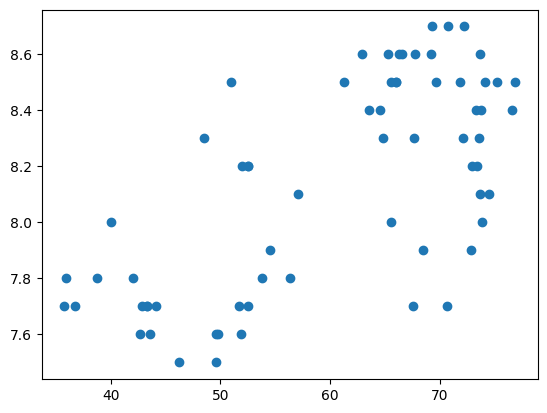

MAE 0.22222039948843328
MSE 0.07346448367204216
RMSE 0.2710433243450983
MAPE 0.027451644957082803
R2 Score 0.5319624839111701
-----For WQI with Salinity  Regression relation-----
40 - 39.78051927265746
40 - 39.90060761902902
35 - 33.79264242084096
24 - 23.70325353597298
38 - 36.91220704954442
39 - 38.940811640375586
37 - 35.87796076203479
32 - 31.604972291769148
39 - 37.93446683188775
16 - 15.001715132083053
20 - 19.126713776955317
35 - 34.77017495798796
25 - 25.640582051773418
40 - 39.73488123514211
20 - 19.412528507213793
25 - 23.685516977479427
40 - 38.95188735322287
34 - 33.118661172446
28 - 28.714508642961516
35 - 35.17607803461799
37 - 35.952411070890975
20 - 19.006625430583753


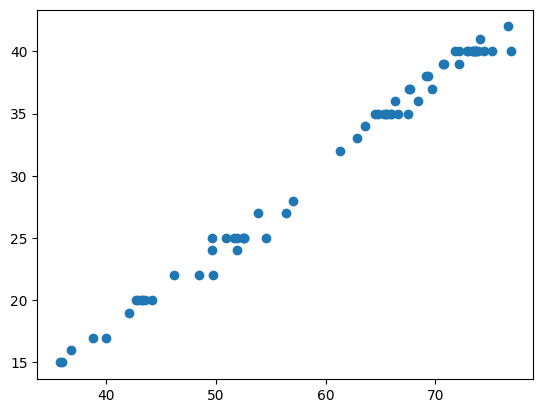

MAE 0.6964823496016161
MSE 0.6458045789417995
RMSE 0.8036196730679256
MAPE 0.024656840314279727
R2 Score 0.9893644079006488
-----For WQI with Ammonia SVR relation-----
0.05 - 0.05005553539948822
0.05 - 0.050089180351570985
0.0 - 0.04837792191038663
0.05 - 0.04555119462308254
0.0 - 0.04925192513903511
0.05 - 0.049820275910076664
0.01 - 0.04896216207845162
0.02 - 0.047765006012304635
0.04 - 0.049538329960421006
0.01 - 0.04311329909457432
0.02 - 0.04426899309771071
0.03 - 0.04865179557394669
0.08 - 0.04609397272813692
0.04 - 0.05004274906649464
0.03 - 0.04434906933486981
0.02 - 0.04554622540101679
0.0 - 0.04982337897410651
0.01 - 0.048189093706051414
0.07 - 0.046955189623791825
0.04 - 0.048765516763188556
0.0 - 0.04898302069754079
0.02 - 0.04423534814562795


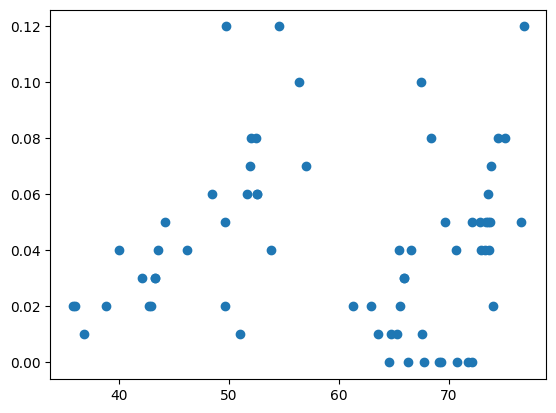

MAE 0.024163087173713568
MSE 0.0008565292268749071
RMSE 0.029266520580262134
MAPE 40212282160685.66
R2 Score -0.6852038447457525


In [225]:
WQI = WQIcalculation(df1 ,GT1)
# len(WQI)
WQIandBands(df1,WQI)
WQIandParameters(np.array(WQI).reshape(-1, 1),GT)

In [ ]:
newdf = bandmath(normalized_Banddata,WQI)

In [68]:
(newdf.columns)

Index(['diff_B11_B12', 'norm_B11_B12', 'ratio_B11_B12', 'diff_B11_B1',
       'norm_B11_B1', 'ratio_B11_B1', 'diff_B11_B2', 'norm_B11_B2',
       'ratio_B11_B2', 'diff_B11_B3',
       ...
       'diff_B8A_B8', 'norm_B8A_B8', 'ratio_B8A_B8', 'diff_B8A_B9',
       'norm_B8A_B9', 'ratio_B8A_B9', 'diff_B8_B9', 'norm_B8_B9',
       'ratio_B8_B9', 'WQI_cal'],
      dtype='object', length=199)

## WQI with  top  10 combination indices

In [69]:
corrwithWQI = newdf.corrwith(newdf['WQI_cal'])
type(corrwithWQI)
corrdict  = corrwithWQI.to_dict()
sortedkeys = sorted(corrdict, key=corrdict.get, reverse=True)
for r in sortedkeys[:11]:
    print(r, corrdict[r])

norm_B11_B12 nan
ratio_B11_B12 nan
diff_B11_B1 0.5858860051643021
norm_B11_B1 nan
ratio_B11_B1 nan
diff_B11_B2 0.4658491561971674
norm_B11_B2 nan
ratio_B11_B2 nan
diff_B11_B4 0.48070141895931656
ratio_B11_B4 0.38649205966089945
diff_B11_B3 0.3626035464330987


In [70]:
newtraindf = newdf[sortedkeys].drop('WQI_cal',axis = 1)
scaler = StandardScaler()
scaler.fit(newtraindf)
newscaledtraindf = scaler.transform(newtraindf)
WQIandBands(newscaledtraindf,WQI)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: ignored

In [22]:
# plt.scatter(df['norm_NarrowNIR_SWIR1'],df['WQI_cal'])
# plt.scatter(df['norm_NarrowNIR_SWIR2'],df['WQI_cal'])
# plt.scatter(df['norm_WaterVapour_SWIR2'],df['WQI_cal'])

## WQI with  PCA 3 bands

In [75]:
pca = PCA(n_components=3)
scaler = StandardScaler()
scaler.fit(Banddata)
scaled_banddata = scaler.transform(Banddata)
pca = PCA(n_components=2)
pca.fit(scaled_banddata)
pca_banddata =  pca.transform(scaled_banddata)

In [76]:
WQIandBands(pca_banddata,WQI)

-----For WQI prediction with Bands-----
MAE 5.458496452142369
MSE 52.319625982997785
RMSE 7.23323067397949
MAPE 0.10711306871020959
R2 Score 0.6091376933765194


array([68.72809614, 68.05966639, 67.77056068, 52.42815373, 68.36026731,
       68.18806405, 59.41466517, 66.9223207 , 67.52235209, 58.81266969,
       53.11104072, 65.37325183, 53.69509358, 65.47501901, 53.9163138 ,
       54.04917639, 68.52627809, 58.04147404, 52.92670339, 65.21070379,
       67.99782643, 53.03684499])